# Определение стоимости автомобилей

**Описание проекта**

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Описание данных**

Данные находятся в файле `/datasets/autos.csv`. 

Признаки
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

Целевой признак
- `Price` — цена (евро)


**Импорт библиотек**

In [1]:
!pip install --upgrade scikit-learn -q
!pip install phik -q
!pip install lightgbm -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import phik
import os
import lightgbm as lgb
import time

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor


from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer

# класс для работы с пропусками
from sklearn.impute import SimpleImputer

from sklearn.metrics import (
    root_mean_squared_error,
    mean_squared_error
)

from sklearn.pipeline import Pipeline

from phik.report import plot_correlation_matrix


RANDOM_STATE = 42

## Подготовка данных

### Загрузка

In [3]:
pth1 = f'/datasets/autos.csv'
pth2 = f'D:/Данные/autos.csv'
    
if os.path.exists(pth1):
    autos = pd.read_csv(pth1)
elif os.path.exists(pth2):
    autos  = pd.read_csv(pth2)
else:
    print('Something is wrong')
    
display(autos.head(2))
display(autos.tail(2))
display(autos.info())     

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

### Предобработка


#### Преобразование наименований столбцов

In [4]:
for col in autos.columns:    

    j = []
    h = []
    
    for i, n in enumerate(col):
        if i> 0 and n.isupper() == True:
            j.append(i)
            h.append(n)            
    
    if len(j) == 1:
        col_name = (col[:j[0]] + '_' + h[0] + col[j[0]+1:]).lower()
        
    elif len(j) == 2:
        col_name = (col[:j[0]] + '_' + h[0] + col[j[0]+1:j[1]] + '_' + h[1] + col[j[1]+1:]).lower()
        
    else:
        col_name = col.lower()
    
    autos = autos.rename(columns={col: col_name})
    

In [5]:
display(autos.columns)

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

#### Обработка дубликатов

In [6]:
display(f'Кол-во дубликатов {autos.duplicated().sum()}')


'Кол-во дубликатов 4'

In [7]:
autos = autos.drop_duplicates().reset_index(drop=True)

display(f'Кол-во дубликатов {autos.duplicated().sum()}')

'Кол-во дубликатов 0'

#### Обработка неявных дубликатов

In [8]:
def func(list_col, data):
    for col_l in list_col:
        print('-'* 50)
        print(col_l, data[col_l].sort_values().unique(), len(data[col_l].sort_values().unique()))    


func(autos[['vehicle_type', 'gearbox', 'model' , 'brand', 'fuel_type' , 'repaired']], autos)
 

--------------------------------------------------
vehicle_type ['bus' 'convertible' 'coupe' 'other' 'sedan' 'small' 'suv' 'wagon' nan] 9
--------------------------------------------------
gearbox ['auto' 'manual' nan] 3
--------------------------------------------------
model ['100' '145' '147' '156' '159' '1_reihe' '1er' '200' '2_reihe' '300c'
 '3_reihe' '3er' '4_reihe' '500' '5_reihe' '5er' '601' '6_reihe' '6er'
 '7er' '80' '850' '90' '900' '9000' '911' 'a1' 'a2' 'a3' 'a4' 'a5' 'a6'
 'a8' 'a_klasse' 'accord' 'agila' 'alhambra' 'almera' 'altea' 'amarok'
 'antara' 'arosa' 'astra' 'auris' 'avensis' 'aveo' 'aygo' 'b_klasse'
 'b_max' 'beetle' 'berlingo' 'bora' 'boxster' 'bravo' 'c1' 'c2' 'c3' 'c4'
 'c5' 'c_klasse' 'c_max' 'c_reihe' 'caddy' 'calibra' 'captiva' 'carisma'
 'carnival' 'cayenne' 'cc' 'ceed' 'charade' 'cherokee' 'citigo' 'civic'
 'cl' 'clio' 'clk' 'clubman' 'colt' 'combo' 'cooper' 'cordoba' 'corolla'
 'corsa' 'cr_reihe' 'croma' 'crossfire' 'cuore' 'cx_reihe' 'defender'
 'delta

In [9]:
autos['model'] = autos['model'].replace('rangerover', 'range_rover')


Gasoline и petrol обозначают один вид топлива - бензин. Объединим в одну категорию "gasoline".

CNG — это метан, а LPG — это пропан и/или бутан. CNG хранится в виде газа, а LPG, сжиженный нефтяной газ, – в виде жидкости, объединить эти виды категорий топлива не получится.


In [10]:
autos.loc[(autos['fuel_type'] == 'petrol'), 'fuel_type'] = 'gasoline'

#### Преобразование типов данных


In [11]:
int64 = autos.select_dtypes(include=['int64']).columns.tolist()
autos[int64] = autos[int64].astype('int32')

display(autos.select_dtypes(include='number').dtypes)   


price                 int32
registration_year     int32
power                 int32
kilometer             int32
registration_month    int32
number_of_pictures    int32
postal_code           int32
dtype: object

#### Удаление неинформативных входных признаков 

Необходимо удалить признаки, которые не содержат характеристики автомобиля и комплектации, а являются параметрами анкеты. Т.е. эти признаки не нужны для обучения модели и получения предсказания цены автомобиля.

In [12]:
autos.drop(columns=['date_crawled', 'date_created', 'number_of_pictures','postal_code', 'last_seen', 'registration_month'],
           axis=1,inplace=True)

#### Обработка пропусков и аномалий

Кол-во пропусков по столбцам:

In [13]:
print(autos.isna().sum())

price                    0
vehicle_type         37490
registration_year        0
gearbox              19833
power                    0
model                19705
kilometer                0
fuel_type            32895
brand                    0
repaired             71154
dtype: int64


In [14]:
display(autos.head(2))


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,gasoline,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes


Категории и кол-во значений в столбцах с пропусками:

In [15]:
for n in ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired']:
    display(n, autos[n].value_counts().head(10))

'vehicle_type'

sedan          91457
small          79830
wagon          65165
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: vehicle_type, dtype: int64

'gearbox'

manual    268249
auto       66283
Name: gearbox, dtype: int64

'model'

golf        29232
other       24420
3er         19761
polo        13066
corsa       12570
astra       10809
passat      10145
a4           9900
c_klasse     8312
5er          7868
Name: model, dtype: int64

'fuel_type'

gasoline    315068
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

'repaired'

no     247158
yes     36053
Name: repaired, dtype: int64

Добавим новый столбец в датафрейм со связкой brand-model для того, чтобы проверить, возможно ли однозначно по бренду и модели автомобиля определить тип кузова для заполнения пропусков.

In [16]:
autos['model_brand'] = autos['model'] + autos['brand']

In [17]:
((
    (
    autos
    .groupby(['model_brand', 'vehicle_type'])
    .agg(cnt=('vehicle_type', 'count'))
              .reset_index()
    )
    .groupby(['model_brand'])
    .agg(cnt_cat=('vehicle_type', 'count'))
    .reset_index()
)
['cnt_cat'].median())
        

5.0

В среднем одному бренду и модели соотвествуют 5 типов кузова, поэтому однозначно выделить значения для заполнения пропусков не получится.

Заполним пропуски значением "unknown". 

Предлагаю заполнить именно этим значением, а не имеющимся в датафрейме "other", т.к. "other" может означать категорию, отличную от имеющихся в базе, но не неизвестное значение.  

Значения для заполнения пропусков в столбцах gearbox, fuel_type невозможно однозначно определить, т.к. одна и та же модель автомобиля может иметь несколько типов коробки передач и видов топлива. Пропуски в данных столбцах также заполним "unknown". 

Модель автомобиля и признак, была ли машина в ремонте или нет, определить никак не получится, поэтому пропуски заполним "unknown". 
В данном случае также не беру для заполнения "other", т.к. "other" может означать категорию, отличную от имеющихся в базе, но не неизвестное значение.  


In [18]:
for n in ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired']:
    autos[n] = autos[n].fillna('unknown')

In [19]:
print(autos.isna().sum())

price                    0
vehicle_type             0
registration_year        0
gearbox                  0
power                    0
model                    0
kilometer                0
fuel_type                0
brand                    0
repaired                 0
model_brand          19705
dtype: int64


После заполнения пропусков обновим также новый столбец модель-бренд:

In [20]:
autos['model_brand'] = autos['model'] + autos['brand']

In [21]:
def draw_number_chart(dataframe):

    for i, col in enumerate(dataframe[dataframe.select_dtypes(include='number').columns.tolist()]):

        x_label = ('Год' if col in ['registration_year'] 
             else 'Евро' if col in ['price']
             else 'Мощность (л. с.)' if col in ['power']                
            else 'Км' if col in ['kilometer']  
                   else 'Количество') 
        title_name = col[0].upper() + col[1:].lower()

        mean_value = dataframe[col].mean()
        median_value = dataframe[col].median()

        plt.figure(i)
        

        fig, axs = plt.subplots(nrows = 1 , ncols = 2, figsize = (12,4))

        sns.histplot(data = dataframe, x = dataframe[col], ax=axs[0], kde=True, bins = 30, legend=True);
        axs[0].axvline(mean_value, linewidth=2, color='orange', alpha=1, linestyle='--', label = 'Среднее = {:.3f}'.format(mean_value))
        axs[0].axvline(median_value, linewidth=2, color='orange', alpha=1, linestyle='-', label = 'Медиана = {:.3f}'.format(median_value))
        axs[0].set_xlabel(x_label)
        axs[0].set_ylabel('Кол-во автомобилей')
        axs[0].legend(fontsize="8")

        sns.boxplot(data = dataframe, x = dataframe[col], ax=axs[1]);
        axs[1].set_xlabel(x_label)
        fig.suptitle(title_name)    
    

In [22]:
autos.describe()

,price,registration_year,power,kilometer
count,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989
std,4514.176349,90.228466,189.851330,37905.083858
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


<Figure size 432x288 with 0 Axes>

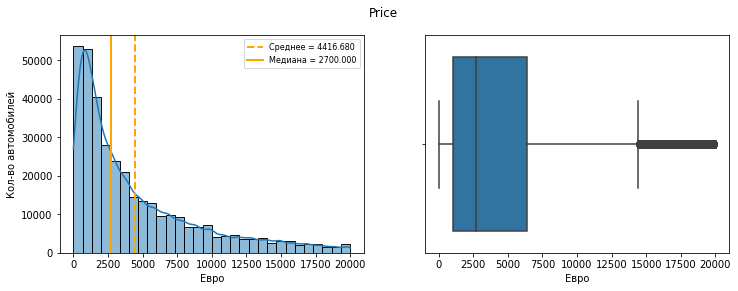

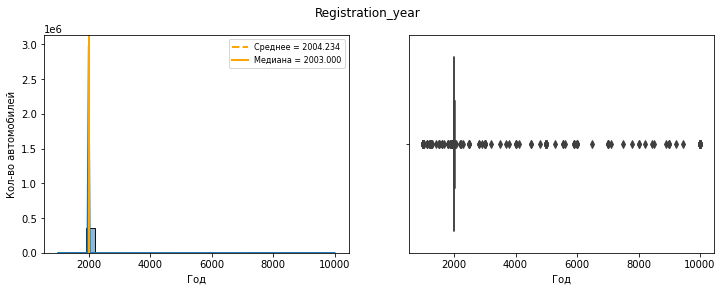

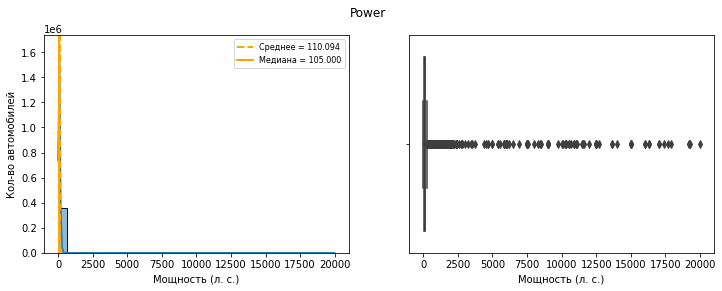

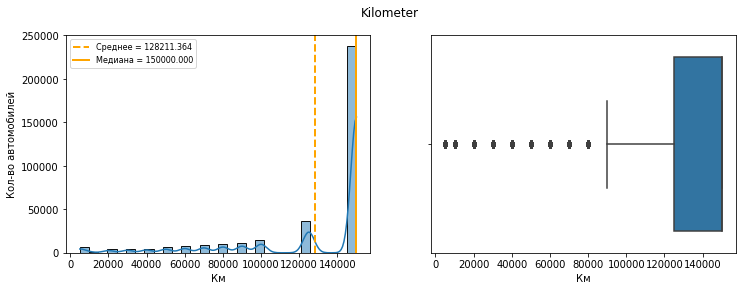

In [23]:
draw_number_chart(autos)

**`price`** 

<AxesSubplot:>

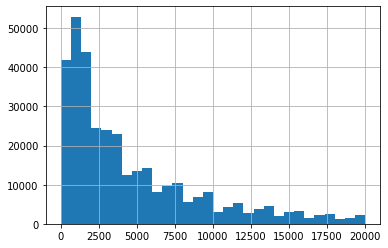

In [24]:
autos.query('price>1')['price'].hist(bins=30)

In [25]:
autos[(autos['price'] < 1)]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,model_brand
7,0,sedan,1980,manual,50,other,40000,gasoline,volkswagen,no,othervolkswagen
40,0,unknown,1990,unknown,0,corsa,150000,gasoline,opel,unknown,corsaopel
111,0,unknown,2017,manual,0,golf,5000,gasoline,volkswagen,unknown,golfvolkswagen
115,0,small,1999,unknown,0,unknown,5000,gasoline,volkswagen,unknown,unknownvolkswagen
152,0,bus,2004,manual,101,meriva,150000,lpg,opel,yes,merivaopel
...,...,...,...,...,...,...,...,...,...,...,...
354201,0,unknown,2000,manual,65,corsa,150000,unknown,opel,yes,corsaopel
354234,0,small,2002,manual,60,fiesta,150000,gasoline,ford,unknown,fiestaford
354244,0,small,1999,manual,53,swift,150000,gasoline,suzuki,unknown,swiftsuzuki
354273,0,small,1999,manual,37,arosa,150000,gasoline,seat,yes,arosaseat


In [26]:
autos[(autos['price'] < 1) & (autos['power'] < 1)]['price'].count()

3865

10,7 тыс. строк с нулевой ценой. Цена - таргет, поэтому вычислить новое значение не получится. 
Из них в 35 % случаев случаев автомобили имеют нулевую мощность.
Предположим, что автомобили с ценой 0, еще не были оценены на момент выгрузки данных, т.к. даже при нулевой мощности автомобиля без двигателя, цена автомобиля будет выше 0.

Удалим 10,7 тыс. строк с нулевой ценой.

In [28]:
autos = autos[autos['price'] > 0]

**`registration_year`** 


In [29]:
(autos.query('registration_year < 1960 or registration_year > 2024')
 .sort_values(by='registration_year', ascending=False)['price']
 .count())

426

349(0,1%) из 354 тысяч строк содержат некорректный год регистрации автомобиля. Удалим эти строки.

In [30]:
autos = autos.query('registration_year >= 1960')
autos = autos.query('registration_year < 2025')

**`power`**

In [31]:
(autos.query('power < 10 or power > 2000')
 .sort_values(by='power', ascending=False)['price']
 .count())

36440

35 тыс. (10%) из 354 тысяч строк содержат информацию о нереалистичном количестве л.с (менее 10 и более 2 тыс.).

Заменим аномалии медианным значением по связке модель-бренд. 

In [32]:
aux_tab = (autos
 .groupby('model_brand')
 .agg(median_power=('power', 'median'))
 .reset_index())

In [33]:
for n in aux_tab[aux_tab['median_power'].isna() == False]['model_brand'].unique():
    autos.loc[(autos['model_brand'] == n) & ((autos['power'] > 2000) | (autos['power'] < 10)), 'power'] = \
    aux_tab.loc[(aux_tab['model_brand'] == n), 'median_power'].values[0]
    

**`Kilometer`**

Значения для признака — пробег, распределены реалистично: от 5 до 150 тыс. км.

**Матрица корреляции $\phi_K$**

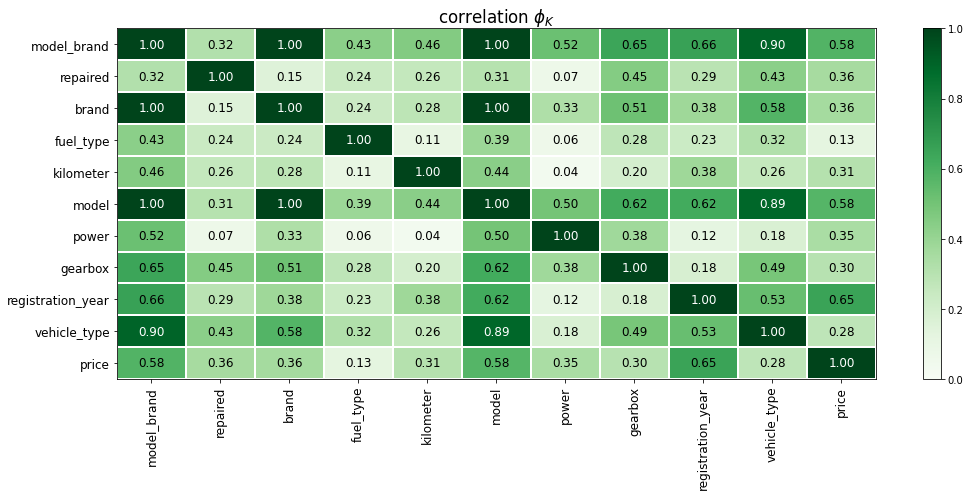

In [34]:
df_corr = autos.phik_matrix(interval_cols=['price', 'registration_year', 'power', 'kilometer'])

plot_correlation_matrix(
    df_corr.values,
    x_labels=df_corr.columns,
    y_labels=df_corr.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.2,
    figsize=(15, 7)
) 
    

Мультиколлинеарность между входными признаками: `model` - `brand`, коэффициент корреляции - 1.

Удалим признаки и оставим объединенный признак для устранения мультиколлинеарности.

In [35]:
autos = autos.drop(['brand', 'model'], axis=1)

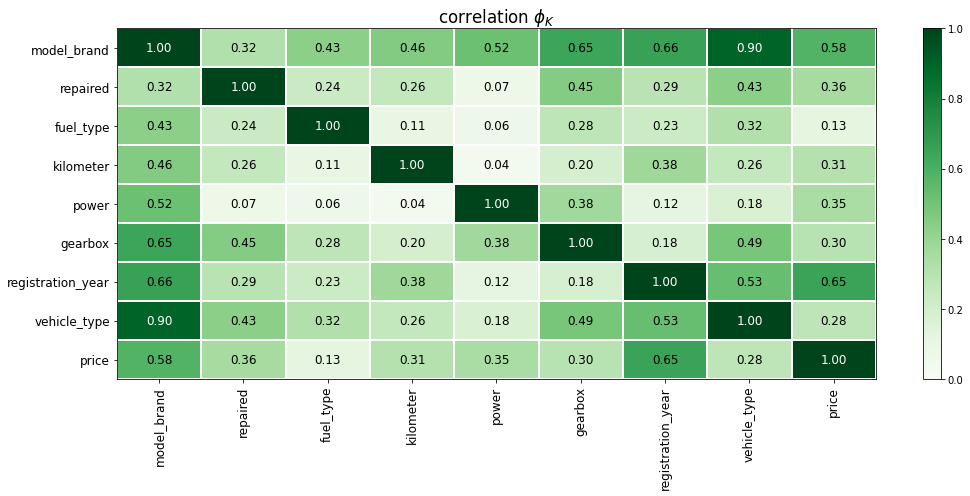

In [36]:
df_corr = autos.phik_matrix(interval_cols=['price', 'registration_year', 'power', 'kilometer'])

plot_correlation_matrix(
    df_corr.values,
    x_labels=df_corr.columns,
    y_labels=df_corr.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.2,
    figsize=(15, 7)
) 
    

#### Промежуточный вывод

После записи датасета в переменную `autos` и первичного знакомства с данными видим, что данные в таблицах соответствуют описанию. 


- Наименования столбцов приведены к "змеиному" регистру.
- Удалены полные дубликаты строк: 4.
- Обработан 1 неявный дубликат.
- Для экономии памяти тип данных в столбце скорректирован с int64 до int32.
- Удалены признаки, которые не содержат характеристики автомобиля и комплектации, а являются параметрами анкеты: 'date_crawled', 'date_created', 'number_of_pictures','postal_code', 'last_seen', 'registration_month'. 
- Пропуски в категориальных признаках `vehicle_type` `gearbox`, `model`, `fuel_type`, `repaired` заполнены значением "unknown". 
- 10,7 тыс. строк с нулевой ценой. Был построен 93 % доверительный интервал и отброшены 3,5 % наибольших и 3,5 % наименьших значений (удалено 25 тыс. строк (около 2%)).
- удалены строки с некорректным годом регистрации автомобиля: 349(0,1%).
- аномальные значения мощности автомобиля - 35 тыс. (10%): заменены медианным значением по связке модель-бренд.
- Значения признака — пробег, распределены реалистично: от 5 до 150 тыс. км.
- Для устранения мультиколлинеарности между входными признаками, имеющими коэффициент корреляции - 1 создан объединенный признак model - brand.





## Обучение моделей

Разделение данных на тренировочную и тестовую выборки:

In [37]:
def prepare_data(df):

    X = df.drop(['price'], axis=1)
    y = df['price']

    X_train, X_test, y_train, y_test = train_test_split(X, y, \
    test_size=0.25, \
    random_state=RANDOM_STATE)
    
    display(f'X_train: {X_train.shape}', 
            f'X_test: {X_test.shape}',
            f'y_train: {y_train.shape}', 
            f'y_test: {y_test.shape}' )

    return X_train, X_test, y_train, y_test

In [38]:
X_train, X_test, y_train, y_test = prepare_data(autos)

'X_train: (257375, 8)'

'X_test: (85792, 8)'

'y_train: (257375,)'

'y_test: (85792,)'

Для обучения модели LightGBM скорректируем тип данных для категориальных признаков на 'category'.

In [39]:
X_train_cat, X_test_cat = X_train, X_test

In [40]:
for col in autos.select_dtypes(exclude='number').columns.tolist():
    X_train_cat[col] = X_train_cat[col].astype('category')
    X_test_cat[col] = X_test_cat[col].astype('category')

**`LightGBM`**

In [41]:
params = [{
    'max_depth': range(4,9),
    'learning_rate': [0.05, 0.1, 0.3, 0.4],
    'num_leaves': range(20, 100, 10)}]

In [42]:
%%time
start = time.time()

model_lgb = LGBMRegressor() 

rs_lgb = RandomizedSearchCV(model_lgb, 
    params, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=10,
    verbose=1
)

rs_lgb.fit(X_train_cat, y_train)

time_value = (time.time() - start)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 3min 56s, sys: 1.11 s, total: 3min 58s
Wall time: 3min 58s


In [43]:
def func_pred(rs):

    best_param_value = rs.best_params_
    best_score_value = rs.best_score_ * (-1)

    mean_fit_time = pd.DataFrame(rs.cv_results_).sort_values(by='rank_test_score').head(1)['mean_fit_time'].values[0] # время обучения
    mean_score_time = pd.DataFrame(rs.cv_results_).sort_values(by='rank_test_score').head(1)['mean_score_time'].values[0] # скорость предсказания
    
    return best_param_value, best_score_value, mean_fit_time, mean_score_time

In [44]:
best_param_value, best_score_value, mean_fit_time, mean_score_time = func_pred(rs_lgb)

df_table = pd.DataFrame({'Модель': ['LightGBM'], 
                         'Общее время обучения на кросс-валидации': time_value, 
                         'Лучшие параметры на кросс-валидации': [best_param_value], 
                         'RMSE на кросс-валидации': best_score_value, 
                         'Среднее время обучения на кросс-валидации': mean_fit_time,                          
                         'Время предсказания ': mean_score_time})

pd.set_option('display.max_colwidth', None)
df_table

,Модель,Общее время обучения на кросс-валидации,Лучшие параметры на кросс-валидации,RMSE на кросс-валидации,Среднее время обучения на кросс-валидации,Время предсказания
0,LightGBM,238.394088,"{'num_leaves': 60, 'max_depth': 7, 'learning_rate': 0.3}",1659.717632,4.799042,0.581417


**`CatBoost`**

In [45]:
params = [{'learning_rate': [0.05, 0.1, 0.3, 0.4],
           'iterations' : range(50, 100, 5),
           'max_depth': range(4,9)}]

In [46]:
%%time
start = time.time()

model_cbr = CatBoostRegressor() 

rs_cbr = RandomizedSearchCV(model_cbr, 
    params, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=10,
    verbose=1
)

rs_cbr.fit(X_train, y_train, cat_features=['vehicle_type', 'gearbox', 'fuel_type', 'repaired', 'model_brand'])

time_value = (time.time() - start)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
0:	learn: 3578.6794191	total: 133ms	remaining: 9.15s
1:	learn: 3055.9570325	total: 199ms	remaining: 6.76s
2:	learn: 2721.6545851	total: 253ms	remaining: 5.64s
3:	learn: 2540.7893803	total: 309ms	remaining: 5.09s
4:	learn: 2419.6556576	total: 376ms	remaining: 4.88s
5:	learn: 2323.6700579	total: 428ms	remaining: 4.56s
6:	learn: 2271.0035000	total: 476ms	remaining: 4.29s
7:	learn: 2235.5547560	total: 529ms	remaining: 4.1s
8:	learn: 2213.9752694	total: 586ms	remaining: 3.97s
9:	learn: 2178.8409882	total: 638ms	remaining: 3.83s
10:	learn: 2153.6476169	total: 694ms	remaining: 3.72s
11:	learn: 2128.9515465	total: 746ms	remaining: 3.61s
12:	learn: 2111.0886139	total: 800ms	remaining: 3.51s
13:	learn: 2102.3149145	total: 854ms	remaining: 3.42s
14:	learn: 2088.0663292	total: 908ms	remaining: 3.33s
15:	learn: 2071.8904244	total: 958ms	remaining: 3.23s
16:	learn: 2059.8041947	total: 1.01s	remaining: 3.15s
17:	learn: 2051.7722861	total: 1

In [47]:
best_param_value, best_score_value, mean_fit_time, mean_score_time = func_pred(rs_cbr)

df_table = df_table.append({'Модель': 'CatBoost', 
                         'Общее время обучения на кросс-валидации': time_value, 
                         'Лучшие параметры на кросс-валидации': [best_param_value], 
                         'RMSE на кросс-валидации': best_score_value, 
                         'Среднее время обучения на кросс-валидации': mean_fit_time,                          
                         'Время предсказания ': mean_score_time}, ignore_index=True)

pd.set_option('display.max_colwidth', None)
df_table


,Модель,Общее время обучения на кросс-валидации,Лучшие параметры на кросс-валидации,RMSE на кросс-валидации,Среднее время обучения на кросс-валидации,Время предсказания
0,LightGBM,238.394088,"{'num_leaves': 60, 'max_depth': 7, 'learning_rate': 0.3}",1659.717632,4.799042,0.581417
1,CatBoost,289.741059,"[{'max_depth': 8, 'learning_rate': 0.3, 'iterations': 90}]",1779.457607,8.675074,0.032834


**`LinearRegression`**

In [48]:
# создаём списки с названиями признаков
ohe_columns = ['vehicle_type', 'gearbox', 'fuel_type', 'repaired', 'model_brand']
num_columns = ['registration_year', 'power', 'kilometer']


# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)) 
    ]
    )

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', RobustScaler(), num_columns)], 
    remainder='passthrough'
)


In [49]:
%%time
start = time.time()

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression( n_jobs= -1))
])

param_grid = [
    
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression(n_jobs= -1)],
        'preprocessor__num': [StandardScaler(), RobustScaler(), 'passthrough']
    }
]


rs_lr = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    n_iter=3
)

rs_lr.fit(X_train, y_train)

time_value = (time.time() - start)


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories

CPU times: user 3min 42s, sys: 1min 12s, total: 4min 54s
Wall time: 4min 55s


In [50]:
best_param_value, best_score_value, mean_fit_time, mean_score_time = func_pred(rs_lr)

df_table = df_table.append({'Модель': 'LinearRegression', 
                         'Общее время обучения на кросс-валидации': time_value, 
                         'Лучшие параметры на кросс-валидации': [best_param_value], 
                         'RMSE на кросс-валидации': best_score_value, 
                         'Среднее время обучения на кросс-валидации': mean_fit_time,                          
                         'Время предсказания ': mean_score_time}, ignore_index=True)

pd.set_option('display.max_colwidth', None)
df_table


,Модель,Общее время обучения на кросс-валидации,Лучшие параметры на кросс-валидации,RMSE на кросс-валидации,Среднее время обучения на кросс-валидации,Время предсказания
0,LightGBM,238.394088,"{'num_leaves': 60, 'max_depth': 7, 'learning_rate': 0.3}",1659.717632,4.799042,0.581417
1,CatBoost,289.741059,"[{'max_depth': 8, 'learning_rate': 0.3, 'iterations': 90}]",1779.457607,8.675074,0.032834
2,LinearRegression,295.503743,"[{'preprocessor__num': StandardScaler(), 'models': LinearRegression(n_jobs=-1)}]",2766.889837,17.514615,0.514209


## Анализ моделей

In [51]:
df_table

,Модель,Общее время обучения на кросс-валидации,Лучшие параметры на кросс-валидации,RMSE на кросс-валидации,Среднее время обучения на кросс-валидации,Время предсказания
0,LightGBM,238.394088,"{'num_leaves': 60, 'max_depth': 7, 'learning_rate': 0.3}",1659.717632,4.799042,0.581417
1,CatBoost,289.741059,"[{'max_depth': 8, 'learning_rate': 0.3, 'iterations': 90}]",1779.457607,8.675074,0.032834
2,LinearRegression,295.503743,"[{'preprocessor__num': StandardScaler(), 'models': LinearRegression(n_jobs=-1)}]",2766.889837,17.514615,0.514209


Метрика RMSE показывает, что предсказание в среднем отличается от истинного значения для модели LightGBM на 1660 евро на кросс-валидации, время обучения модели на кросс-валидации составляет 5 секунд, время предсказания - менее секунды.

Для модели CatBoost метрика RMSE составляет 1780 евро на кросс-валидации, время обучения модели на кросс-валидации составляет 9 секунд, время предсказания - менее десятой доли секунды.

Для модели линейной регресии метрика RMSE составляет 2767 евро на кросс-валидации, время обучения модели на кросс-валидации составляет 17 секунд, время предсказания - менее секунды.

Итак, наилучшее качество предсказания дает модель LightGBM с параметрами: 
- максимальное количество листьев дерева - 60.
- максимальная глубина дерева - 7.
- скорость обучения для процесса градиентного бустинга - 0.3.

In [52]:
pred = rs_lgb.predict(X_test_cat)
rmse_score_test = round(root_mean_squared_error(y_test, pred), 5)

print('Метрика RMSE лучшей модели на тестовой выборке: ', rmse_score_test)

Метрика RMSE лучшей модели на тестовой выборке:  1650.77799


             Feature  Importance
1  registration_year        1442
3              power        1441
7        model_brand        1286
4          kilometer         723
0       vehicle_type         364
6           repaired         239
2            gearbox         198
5          fuel_type          36


<AxesSubplot:title={'center':'Важность признаков'}, ylabel='Feature'>

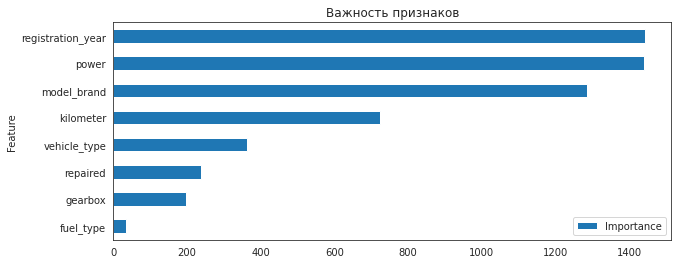

In [53]:
feature_importances = pd.DataFrame(
    {
        'Feature': X_train_cat.columns,
        'Importance': rs_lgb.best_estimator_.feature_importances_
    })

print(feature_importances.sort_values('Importance', ascending=False))
sns.set_style('white')
(feature_importances
 .sort_values('Importance', ascending=True)
 .plot(x='Feature', y='Importance', kind='barh', figsize=(10, 4), title='Важность признаков')) 

На графике показана важность признаков в порядке убывания.
Наибольшее влияние оказывают: год регистрации, мощность, модель и бренд автомобиля. Наименьшее - тип топлива.

## Общий вывод

На основе данных о технических характеристиках, комплектации и ценах других автомобилей для предсказания рыночной стоимости автомобиля были обучены 3 модели: LightGBM, CatBoost, LinearRegression.

После записи датасета в переменную `autos` и первичного знакомства с данными видим, что данные в таблицах соответствуют описанию. 

**Предобработка данных**

- Наименования столбцов приведены к "змеиному" регистру.
- Удалены полные дубликаты строк: 4.
- Обработан 1 неявный дубликат.
- Для экономии памяти тип данных в столбце скорректирован с int64 до int32.
- Удалены признаки, которые не содержат характеристики автомобиля и комплектации, а являются параметрами анкеты: 'date_crawled', 'date_created', 'number_of_pictures','postal_code', 'last_seen', 'registration_month'. 
- Пропуски в категориальных признаках `vehicle_type` `gearbox`, `model`, `fuel_type`, `repaired` заполнены значением "unknown". 
- 10,7 тыс. строк с нулевой ценой. Был построен 93 % доверительный интервал и отброшены 3,5 % наибольших и 3,5 % наименьших значений (удалено 25 тыс. строк (около 2%)).
- удалены строки с некорректным годом регистрации автомобиля: 349(0,1%).
- аномальные значения мощности автомобиля - 35 тыс. (10%): заменены медианным значением по связке модель-бренд.
- Значения признака — пробег, распределены реалистично: от 5 до 150 тыс. км.
- Для устранения мультиколлинеарности между входными признаками, имеющими коэффициент корреляции - 1 создан объединенный признак model - brand.


Метрика RMSE показывает, что предсказание в среднем отличается от истинного значения для модели LightGBM на 1660 евро на кросс-валидации, время обучения модели на кросс-валидации составляет 5 секунд, время предсказания - менее секунды.

Для модели CatBoost метрика RMSE составляет 1780 евро на кросс-валидации, время обучения модели на кросс-валидации составляет 9 секунд, время предсказания - менее десятой доли секунды.

Для модели линейной регресии метрика RMSE составляет 2767 евро на кросс-валидации, время обучения модели на кросс-валидации составляет 17 секунд, время предсказания - менее секунды.

Итак, наилучшее качество предсказания дает модель LightGBM с параметрами: 
- максимальное количество листьев дерева - 60.
- максимальная глубина дерева - 7.
- скорость обучения для процесса градиентного бустинга - 0.3.

Модель LightGBM затрачивает в 2 раза меньше времени, чем CatBoost, при этом в 10 раз меньше времени на предсказание тратит модель CatBoost.

Таким образом, можно рекомендовать заказчику использовать модель LightGBM.

Метрика качества лучшей модели на тестовой выборке: 1651.
Наибольшее влияние на моделирование среди входных признаков оказывают: год регистрации, мощность, модель и бренд автомобиля, наименьшее - тип топлива.


## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей